## Detecting and Classifying Malicious Uniform Resource Locations Using Advanced Machine Learning

In [2]:
from urllib.parse import urlsplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import warnings
warnings.filterwarnings('ignore')

In [3]:

df = pd.read_csv(r"C:\\Malicious URL Detection\malicious_phish.csv")
df.head(50)

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign
8,http://www.pashminaonline.com/pure-pashminas,defacement
9,allmusic.com/album/crazy-from-the-heat-r16990,benign


In [4]:
#@title General Info
df.describe()

,url,type
count,651191,651191
unique,641119,4
top,http://style.org.hc360.com/css/detail/mysite/s...,benign
freq,180,428103


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


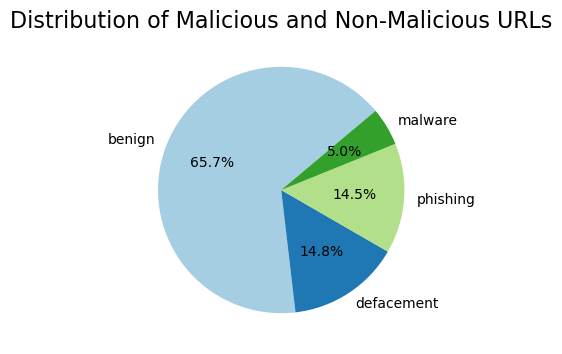

In [6]:
plt.figure(figsize=(4, 4))
type_counts = df['type'].value_counts()
type_counts.plot(kind='pie', autopct='%1.1f%%', startangle=40, colors=plt.cm.Paired(range(len(type_counts))))

# Add a title and remove the ylabel
plt.title('Distribution of Malicious and Non-Malicious URLs', fontsize=16)
plt.gca().set_ylabel('')

# Display the chart
plt.show()

# Preprocessing

In [7]:

df['ext_type'] = df['url'].apply(lambda x: urlsplit(x).path.rsplit('.', 1)[-1] if '.' in urlsplit(x).path else 'None')

value_counts = df['ext_type'].value_counts()
values_to_replace = value_counts.nlargest(8).index

df.loc[~df['ext_type'].isin(values_to_replace), 'ext_type'] = 'None'

df['has_http'] = df['url'].str.contains('http://').astype(int)

df['has_org'] = df['url'].str.contains('org').astype(int)

df['has_query'] = df['url'].str.contains('\?').astype(int)

df['count_routes'] = df['url'].str.replace('http://', '').str.count('/')

df['count_routes'] = df['count_routes'].where(df['count_routes'] <= 4, 4)

In [8]:
df.head()

,url,type,ext_type,has_http,has_org,has_query,count_routes
0,br-icloud.com.br,phishing,None,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,html,0,0,0,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,htm,0,1,0,3
3,http://www.garage-pirenne.be/index.php?option=...,defacement,php,1,0,1,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,php,1,0,1,1


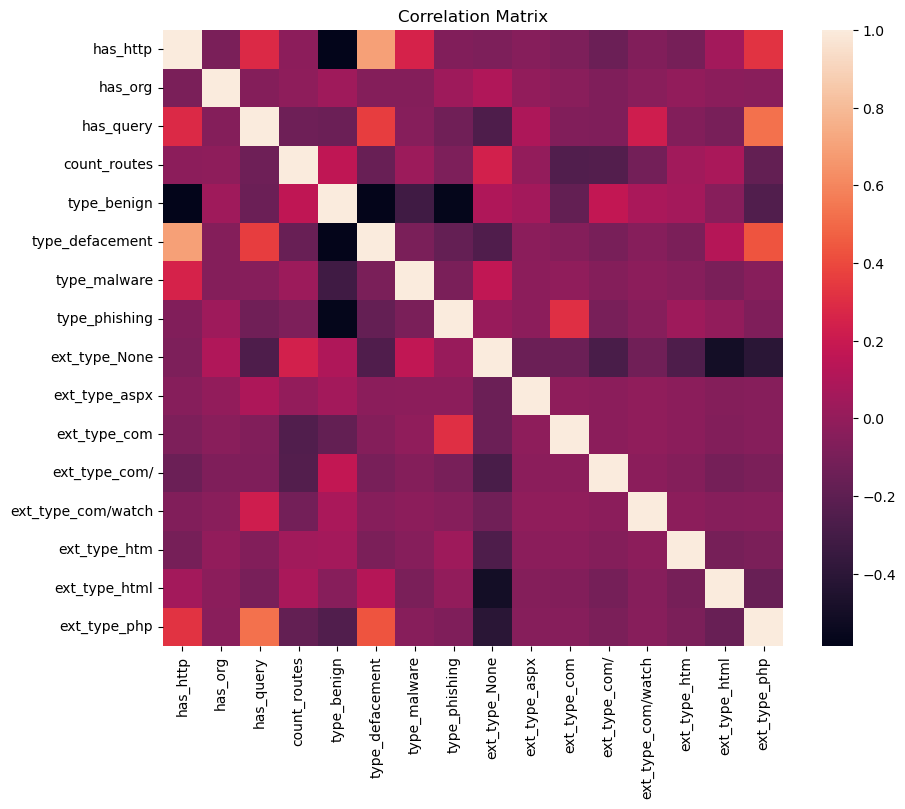

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(pd.get_dummies(df.iloc[:, 1:]).corr())
plt.title('Correlation Matrix')
plt.show()

In [10]:
y_mapping = {
    0:'benign',
    1:'defacement',
    2:'malware',
    3:'phishing'
}

df['count_routes'] = df['count_routes'].astype(str)

X,y = pd.get_dummies(df.iloc[:, 2:]), df['type'].replace({v: k for k, v in y_mapping.items()})

In [11]:
df.iloc[:, 2:]

,ext_type,has_http,has_org,has_query,count_routes
0,None,0,0,0,0
1,html,0,0,0,2
2,htm,0,1,0,3
3,php,1,0,1,1
4,php,1,0,1,1
...,...,...,...,...,...
651186,html,0,0,0,3
651187,None,0,0,0,4
651188,None,0,0,0,4
651189,None,0,1,0,2


In [12]:
y

0         3
1         0
2         0
3         1
4         1
         ..
651186    3
651187    3
651188    3
651189    3
651190    3
Name: type, Length: 651191, dtype: int64

In [13]:
X

,has_http,has_org,has_query,ext_type_None,ext_type_aspx,ext_type_com,ext_type_com/,ext_type_com/watch,ext_type_htm,ext_type_html,ext_type_php,count_routes_0,count_routes_1,count_routes_2,count_routes_3,count_routes_4
0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0
4,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
651187,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
651188,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
651189,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [14]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# Perform random undersampling to balance the classes
rus = RandomUnderSampler(random_state=49)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Split samples
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print('X_train shape is', X_train.shape)
print('y_train shape is', y_train.shape)
print('X_test shape is', X_test.shape)
print('y_test shape is', y_test.shape)

print(pd.value_counts(y_train))

X_train shape is (104064, 16)
y_train shape is (104064,)
X_test shape is (26016, 16)
y_test shape is (26016,)
2    26093
3    26056
1    25963
0    25952
Name: type, dtype: int64


In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
rf=RandomForestClassifier(n_estimators=300,criterion='gini',min_samples_split=5,min_samples_leaf=1,max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,)

In [17]:
rf.fit(X_train,y_train)

RandomForestClassifier(min_samples_split=5, n_estimators=300)

In [18]:
# Make predictions on the testing data
y_pred = rf.predict(X_test)
#y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluate the model's accuracy
#accuracy = accuracy_score(y_test, y_pred)
#print("Accuracy:", accuracy)
cm=confusion_matrix(y_test, y_pred)
print(cm)

conf_matrix =cm
# Calculate the values from the confusion matrix
TN, FP = conf_matrix[0][0], conf_matrix[0][1]
FN, TP = conf_matrix[1][0], conf_matrix[1][1]

# Calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)
print("training Accuracy:", accuracy)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

[[4390  256  976  946]
 [   0 5422 1095   40]
 [  68  480 5575  304]
 [2058  364  934 3108]]
training Accuracy: 0.9745729042510926
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67      6568
           1       0.83      0.83      0.83      6557
           2       0.65      0.87      0.74      6427
           3       0.71      0.48      0.57      6464

    accuracy                           0.71     26016
   macro avg       0.72      0.71      0.70     26016
weighted avg       0.72      0.71      0.70     26016



In [19]:
y_pred = rf.predict(X_test)
print(y_pred)

[0 0 0 ... 0 2 0]


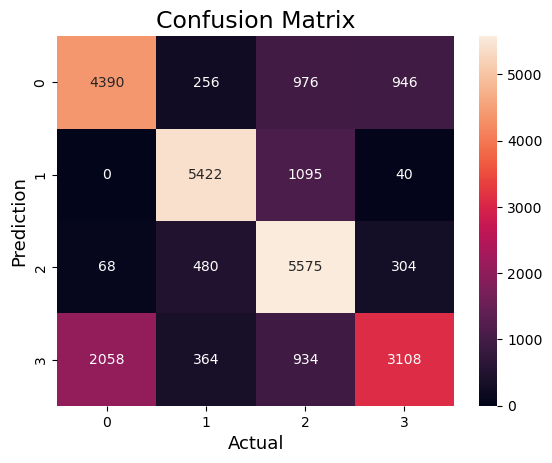

In [24]:
#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()